# Sunspot Data

https://www.kaggle.com/datasets/abhinand05/daily-sun-spot-data-1818-to-2019?resource=download&select=sunspot_data.csv

https://datatofish.com/import-csv-file-python-using-pandas/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv (r'Data/SN_d_tot_V2.0.csv', delimiter=';')
df.head()

Year  Month  Day  Date in Fraction of Year  Number of Sunspots  \
0  1818      1    1                  1818.001                  -1   
1  1818      1    2                  1818.004                  -1   
2  1818      1    3                  1818.007                  -1   
3  1818      1    4                  1818.010                  -1   
4  1818      1    5                  1818.012                  -1   

   Standard Deviation  Observations  Indicator  
0                -1.0             0          1  
1                -1.0             0          1  
2                -1.0             0          1  
3                -1.0             0          1  
4                -1.0             0          1

In [3]:
xcol = 'Date in Fraction of Year'
ycol = 'Number of Sunspots'

## SVG Smoothing

The data we have is very noisy. In order to paint a picture as to what is going on one thing we might want to do is **smooth** the data. We do this using a ***Savitzky-Golay Filter*** (SVG). This works by fitting a sub-set of adjacent data points with a low-degree polynomial by the method of linear least squares. When the data points are equally spaced, an analytical solution to the least-squares equations can be found  in the form of a single set of "convolution coefficients" that can be applied to all data sub-sets, to give estimates of the smoothed signal. https://en.wikipedia.org/wiki/Savitzky–Golay_filter

For a data set with points $\{x_j, y_j\}, j = 1, \dots, n$, with $m$ convolution coefficients given by $C_i$. Our smoothed signal $Y_j$ is given by:

$$Y_j = \sum_{i = \frac{1-m}{2}}^{\frac{m-1}{2}} C_i y_{i+j}$$ 

$\frac{m+1}{2} \leq j \leq n - \frac{m-1}{2} $

Fortunately, the Scipy module has a module which calculates the SVG for us. https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html

In [4]:
from scipy.signal import savgol_filter

In [5]:
window_length = int(4*365) + 1 # the number of coefficients --> must be odd
poly_order = [1, 2, 4] # order of the polynomial used to fit the samples
color = ['deeppink', 'tab:blue', 'tab:green', 'lightgrey']
zorder = [99, 98, 97]
size = len(poly_order)
smoothed = [savgol_filter(df[ycol], window_length, poly_order[i]) for i in range(size)]

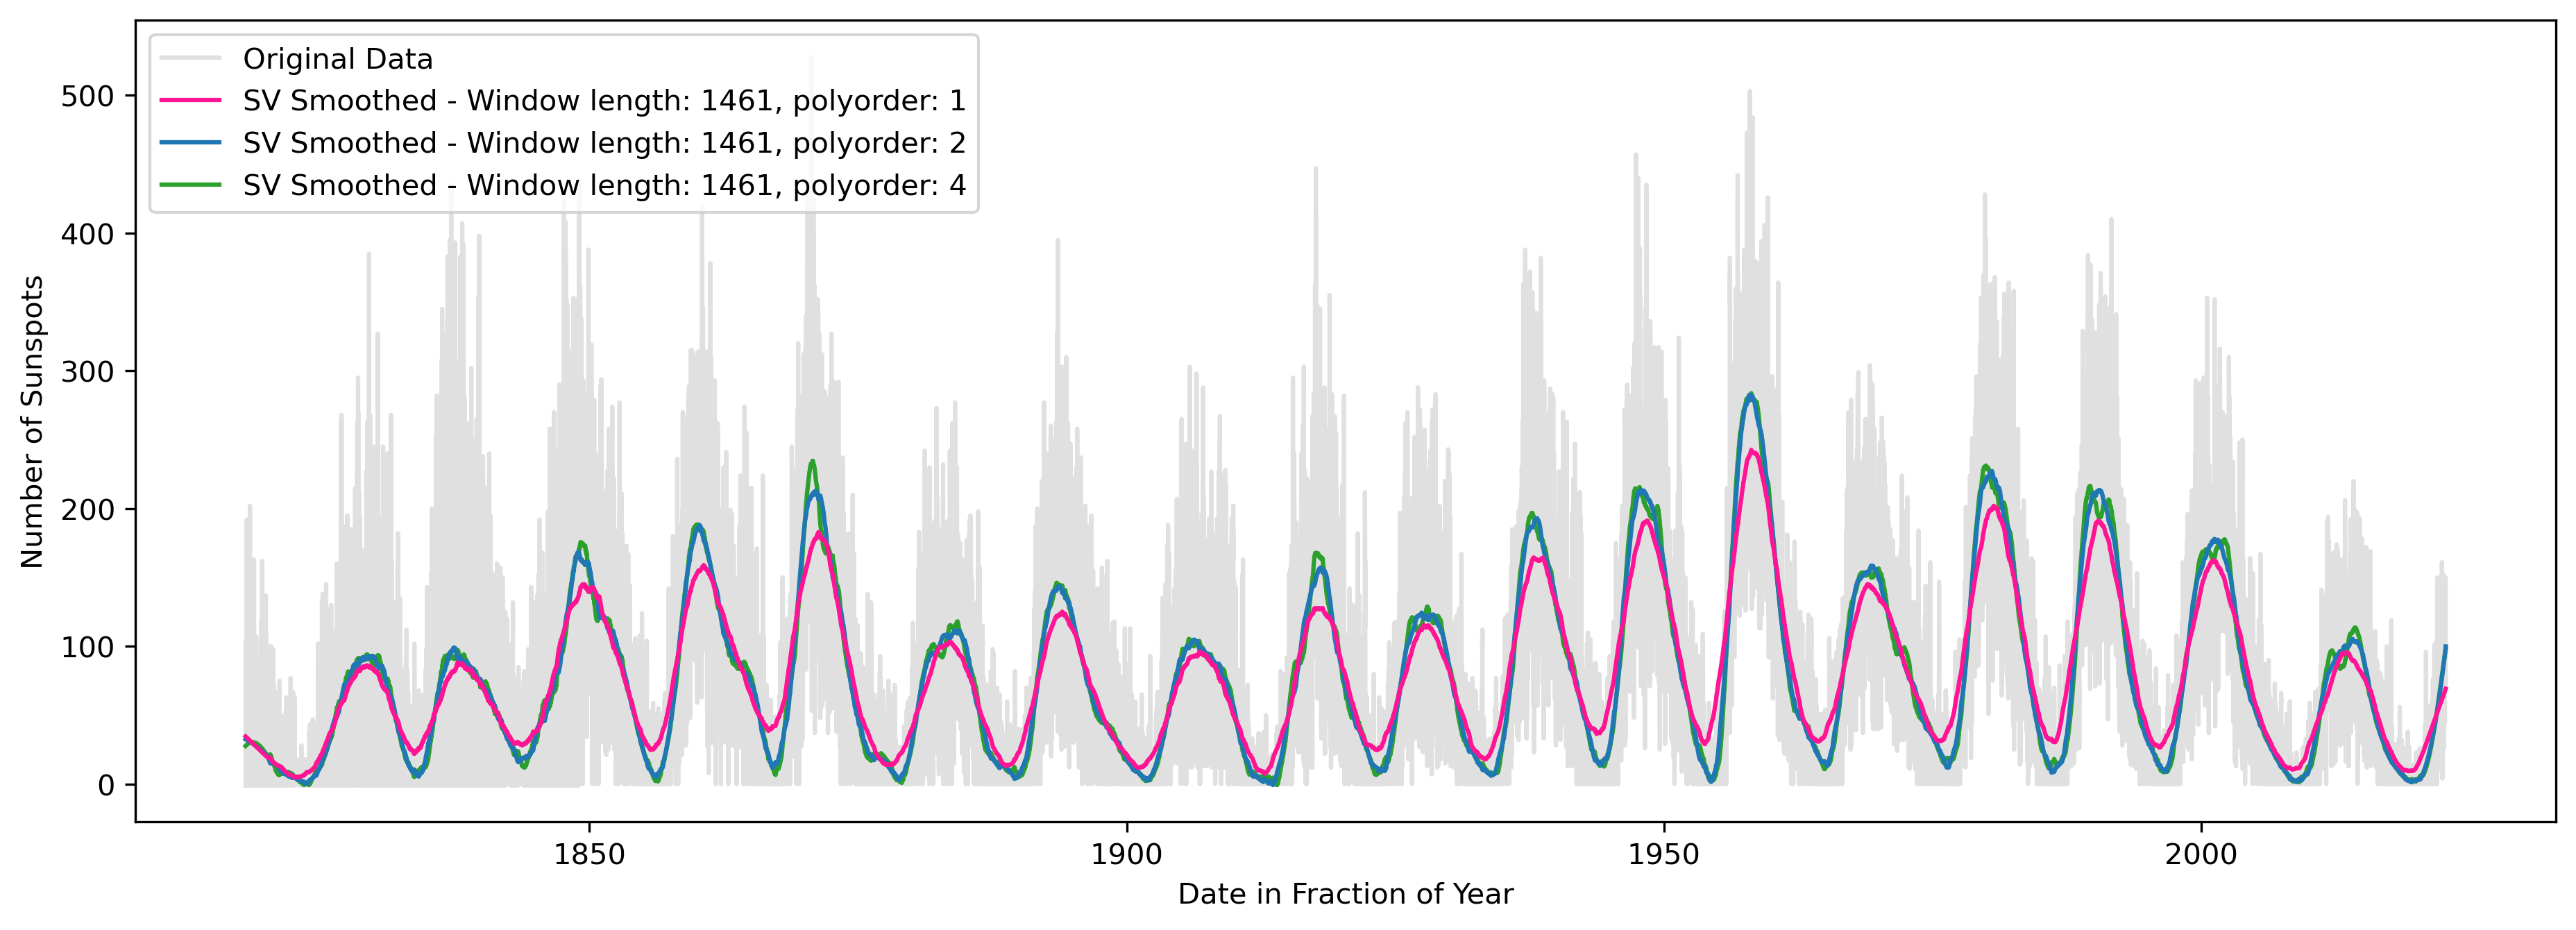

In [6]:
alpha=0.7 # determines opacity
 
fig, ax = plt.subplots(dpi=300, figsize=[15, 5])
ax.plot(df[xcol], df[ycol], alpha=alpha, label='Original Data', color=color[-1])
for i in range(size):
    ax.plot(df[xcol], smoothed[i],
        label=f'SV Smoothed - Window length: {window_length}, polyorder: {poly_order[i]}', 
       zorder=zorder[i], color = color[i])
ax.set_xlabel(xcol)
ax.set_ylabel(ycol)
ax.legend()
fig.savefig('svg_plot.png');

#### Comment on plot:

The plot above shows the noisy data in blue, as well as two different SVG smoothed signals, both with the same window length, but different polyorders. The two signals show the extent of how noisy the data is. We can see that for each cycle the smoothed amplitude is much lower than the maximum suggested by the data.

The orange line (polyorder = 1) shows a smoother fit, containing fewer turning points than the green line. We can use this line to find the turning points, and from there determine the amplitude of the peaks so that we can see if there is a pattern to the cycle amplitude.

## Phase Diagram

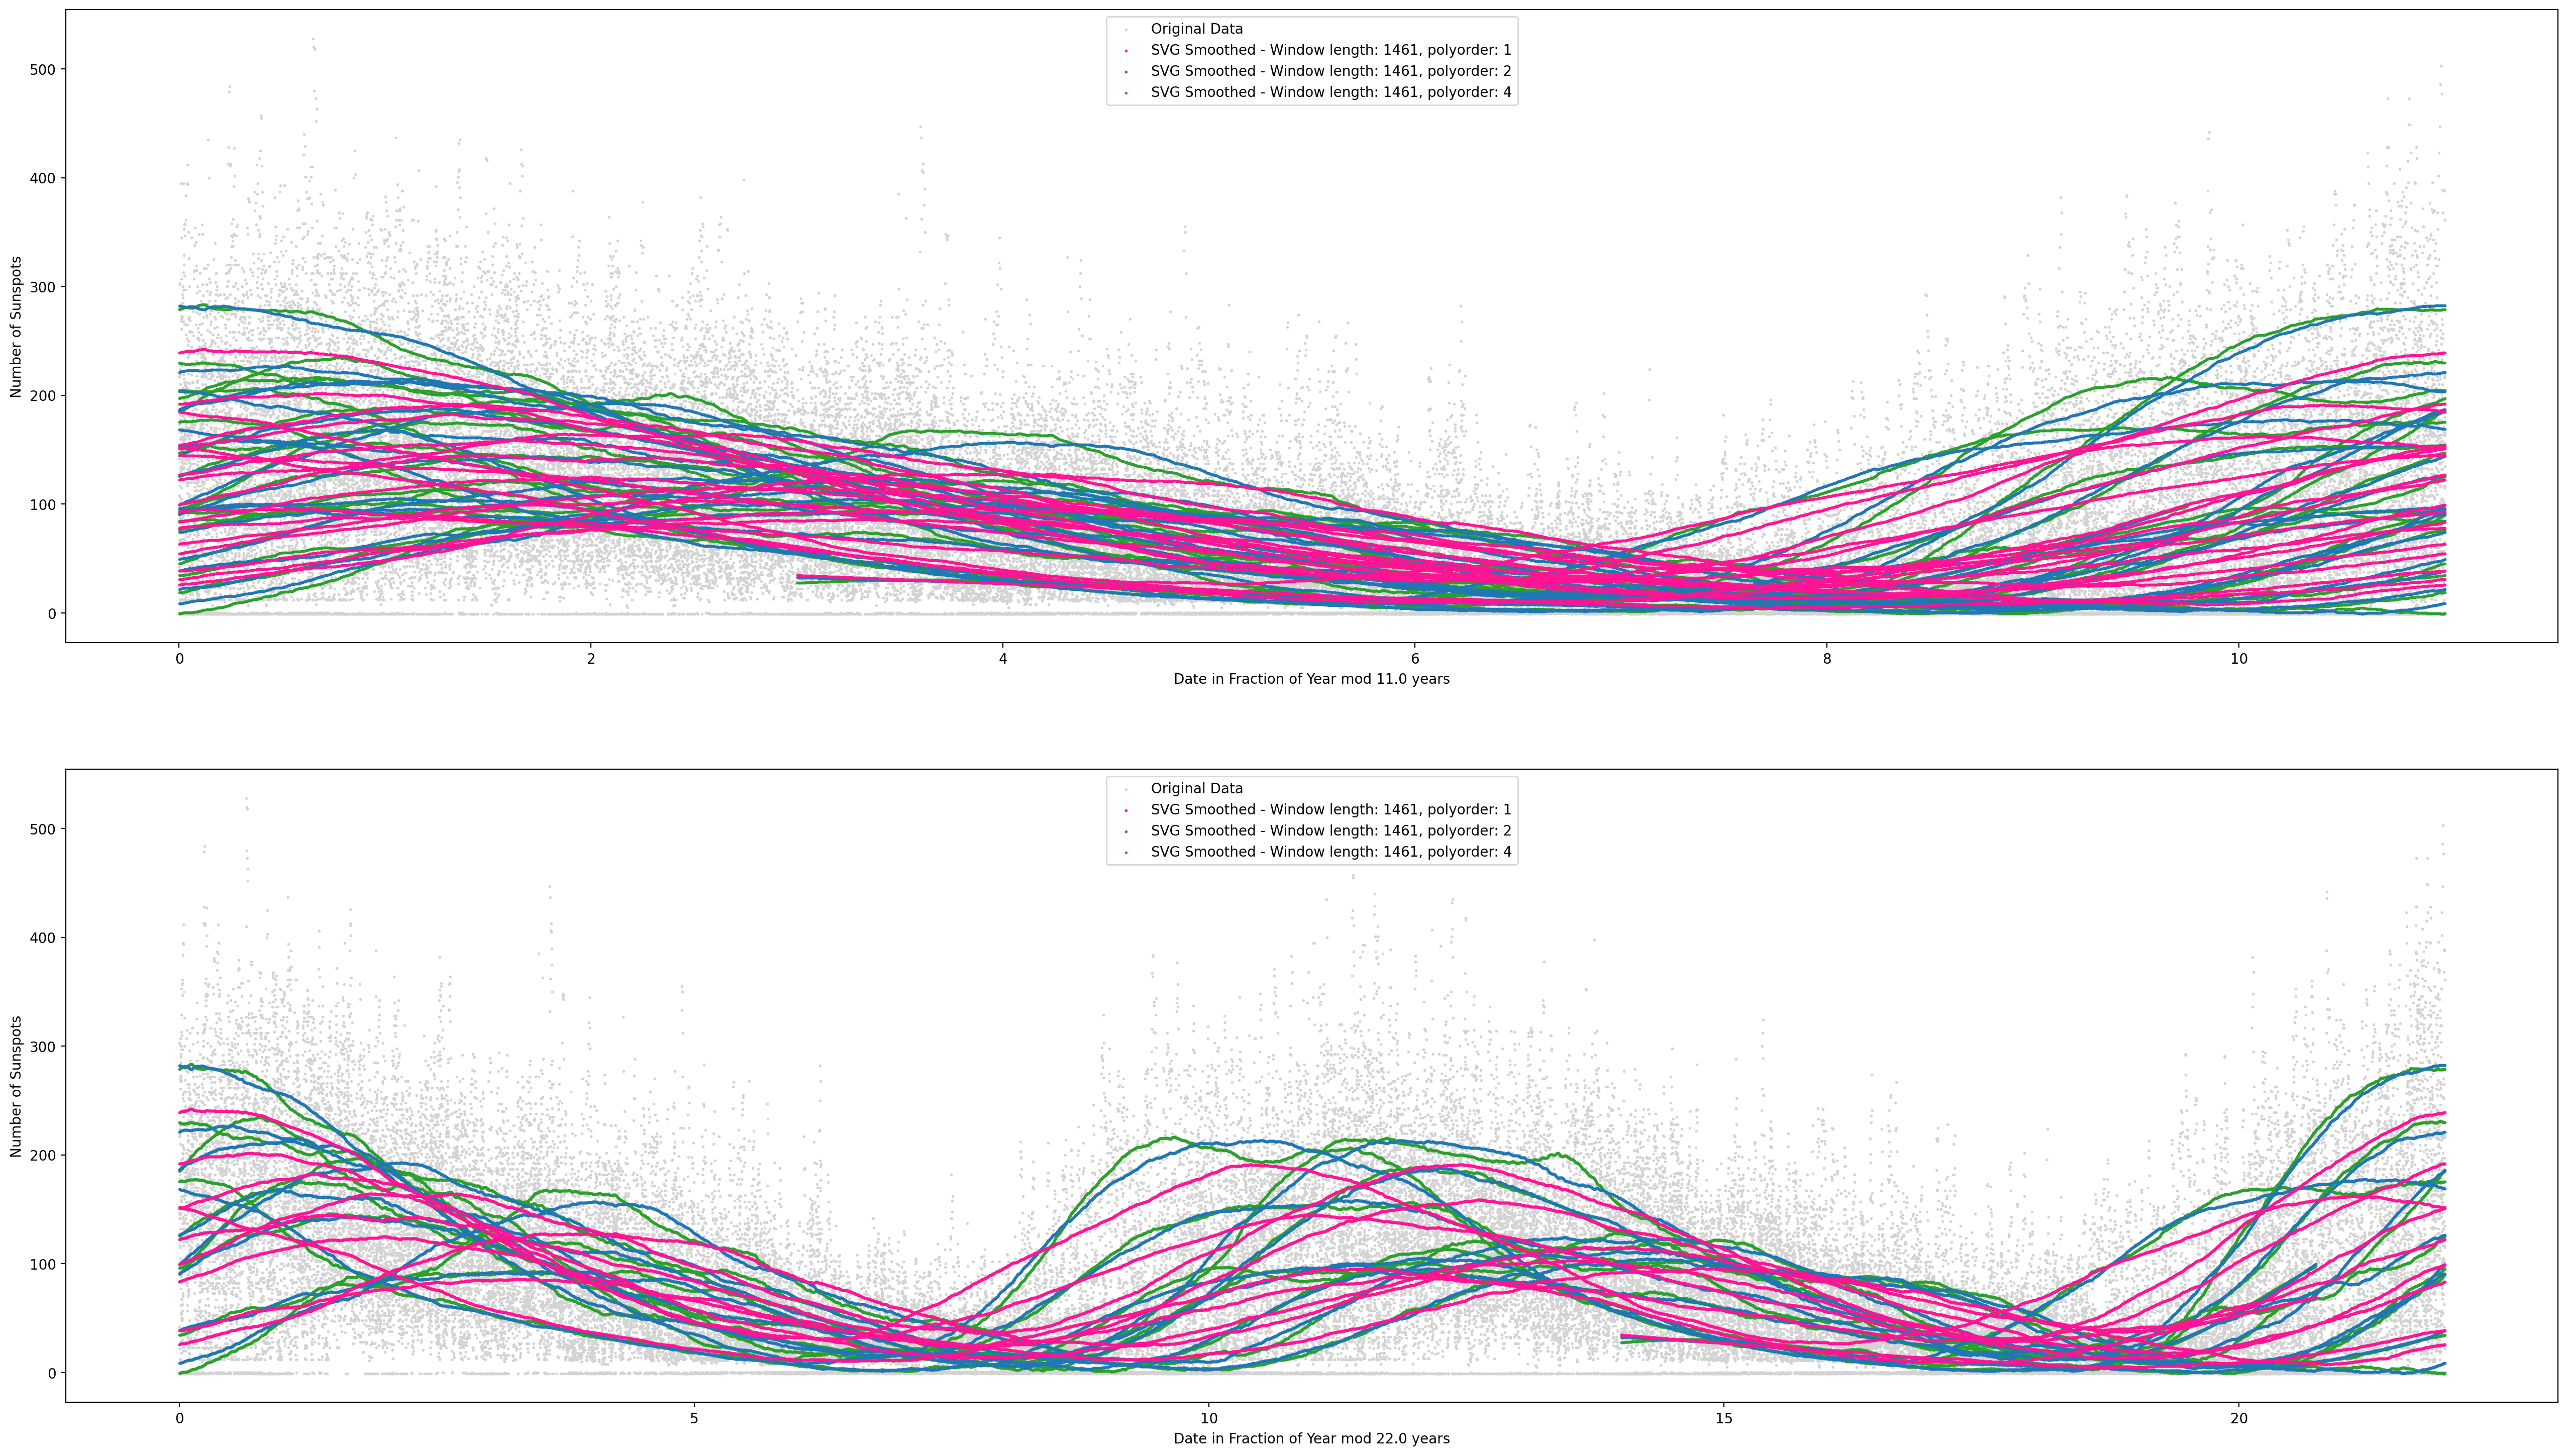

In [7]:
''' Plotting a Phase Diagram '''

time = df[xcol].values
period = [11,22]
phase = [time % (period[i]) for i in range(2)]
s=1 # determines point size

fig, ax = plt.subplots(2, dpi=200, figsize=[32, 18])
for i in range(2):
    ax[i].scatter(phase[i], df[ycol], label='Original Data', color=color[-1],s=s)
    for j in range(size):
        ax[i].scatter(phase[i], smoothed[j], 
                      label=f'SVG Smoothed - Window length: {window_length}, polyorder: {poly_order[j]}',
                      zorder=zorder[j], color=color[j], s=s)
        ax[i].set_xlabel(xcol + f' mod {period[i]:.1f} years')
        ax[i].set_ylabel(ycol)
        ax[i].legend();

#### Comment on plot:

The plots above show a phase diagram of how each solar cycle's length compares to our estimate of 11 years. The code works by finding the remainder when time is divided by our estimate. If all the cycles had the exact same period (11 years) then the graph would form a sine-squared. 

To show the extent of how out of phase the cycles are, I have also plotted a graph for period = 22 years. Both of the above graphs are offset due to the initial data not beginning with a minima. We can fix this by finding the minima and using it to determine our x-offset.

From this graph we can conclude that the solar cycles do not all have a period of 11 years. For future work we could try and find minimise the phase difference to find which period most accurately describes the average solar cycle.

## Finding the Peaks

The method used to find the peaks of the SVG signal is to find the positions of the turning points (in years) and then find the amplitude it corresponds to. Scipy has a built-in peak-finder, which can find the peaks for us. https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

It also has a built-in function to find the minima https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelmin.html

In [8]:
from scipy.signal import find_peaks
from scipy.signal import argrelmin

In [9]:
peaks = [find_peaks(smoothed[i], height=80, distance=1800) for i in range(size)]
troughs = [argrelmin(smoothed[i], order=1000) for i in range(size)]

maxima = [smoothed[i][peaks[i][0]] for i in range(size)]
minima = [smoothed[i][troughs[i][0]] for i in range(size)]

dates_peak = [df[xcol][peaks[i][0]] for i in range(size)] # dates of the maxima for each SVG signal
dates_minima = [df[xcol][troughs[i][0]] for i in range(size)] # dates of the minima for each SVG signal

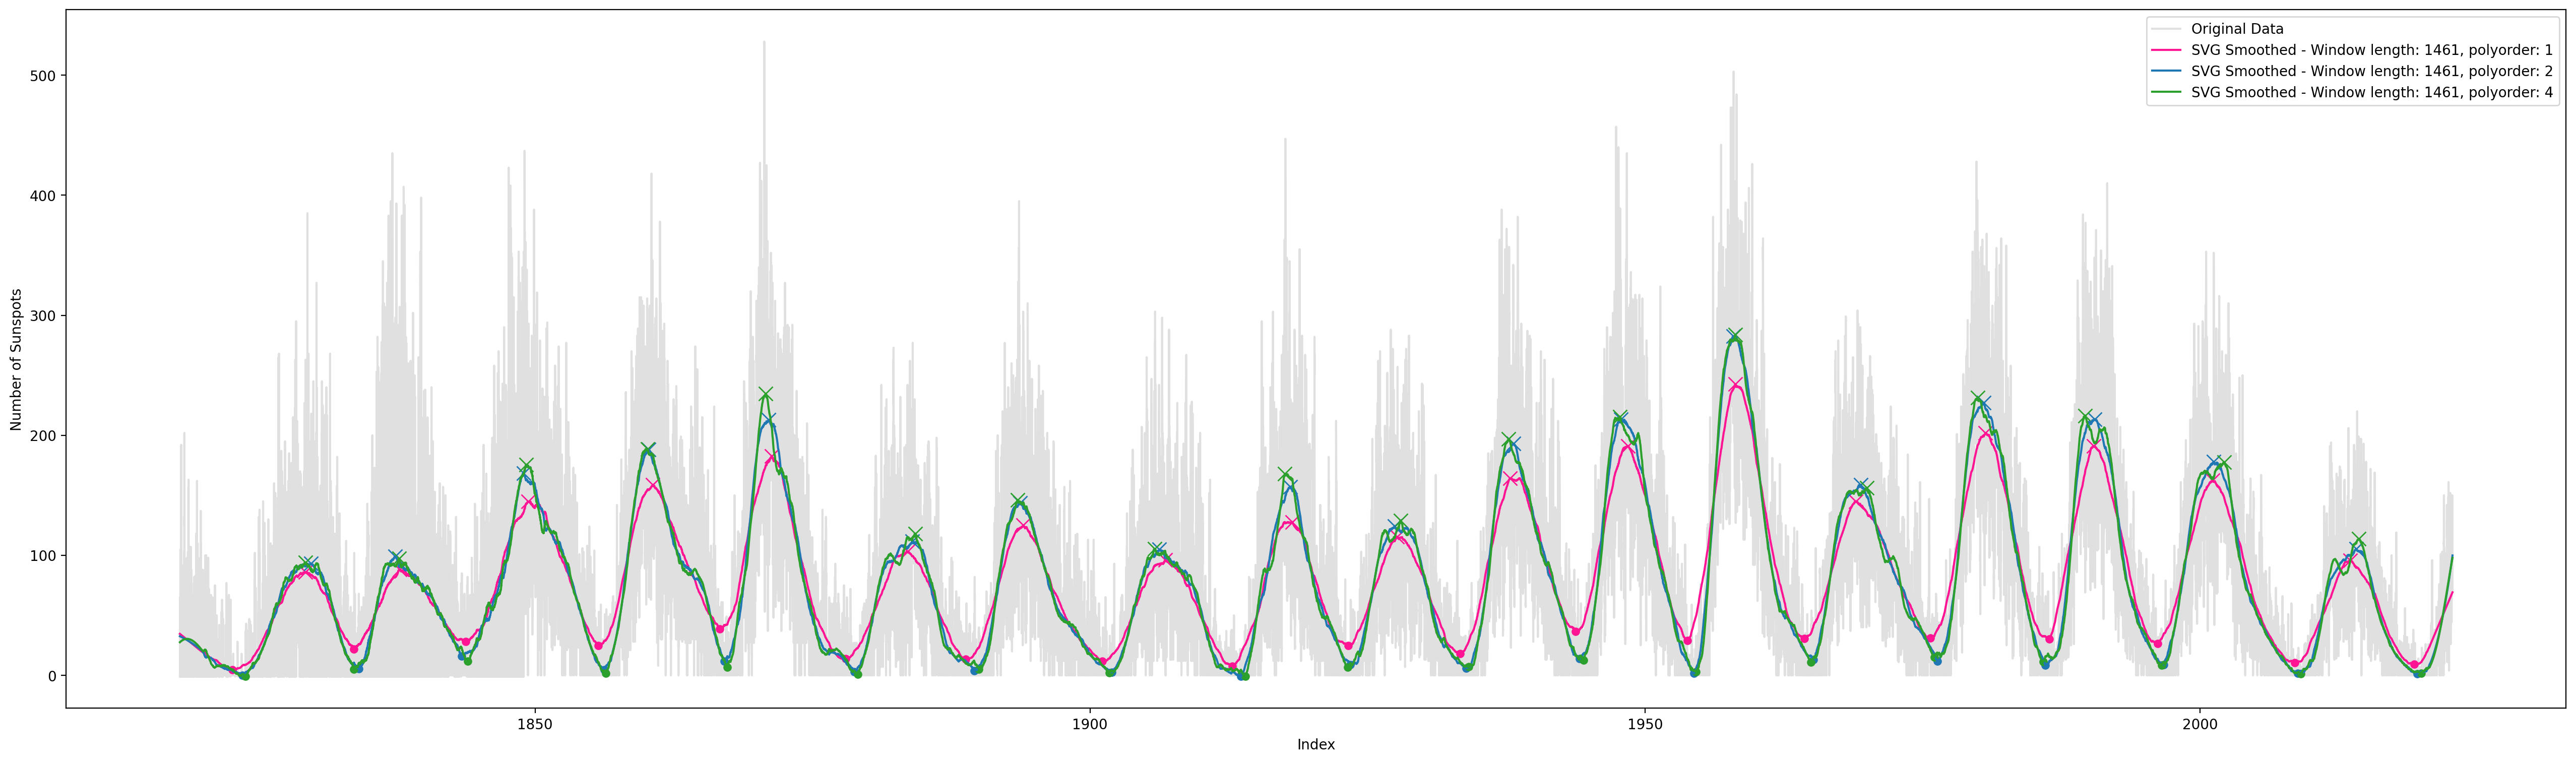

In [10]:
msize = 10 # size of marker

fig, ax = plt.subplots(dpi=200, figsize=[32, 9])
ax.plot(df[xcol], df[ycol], alpha=alpha, label='Original Data', color=color[-1])
for i in range(size):
    ax.plot(df[xcol], smoothed[i],
        label=f'SVG Smoothed - Window length: {window_length}, polyorder: {poly_order[i]}', 
       zorder=99, color=color[i])
    ax.plot(dates_peak[i], maxima[i], 'x', color=color[i], markersize=msize)
    ax.plot(dates_minima[i], minima[i], '.', color=color[i], markersize=msize)
ax.set_xlabel('Index')
ax.set_ylabel(ycol)
ax.legend();

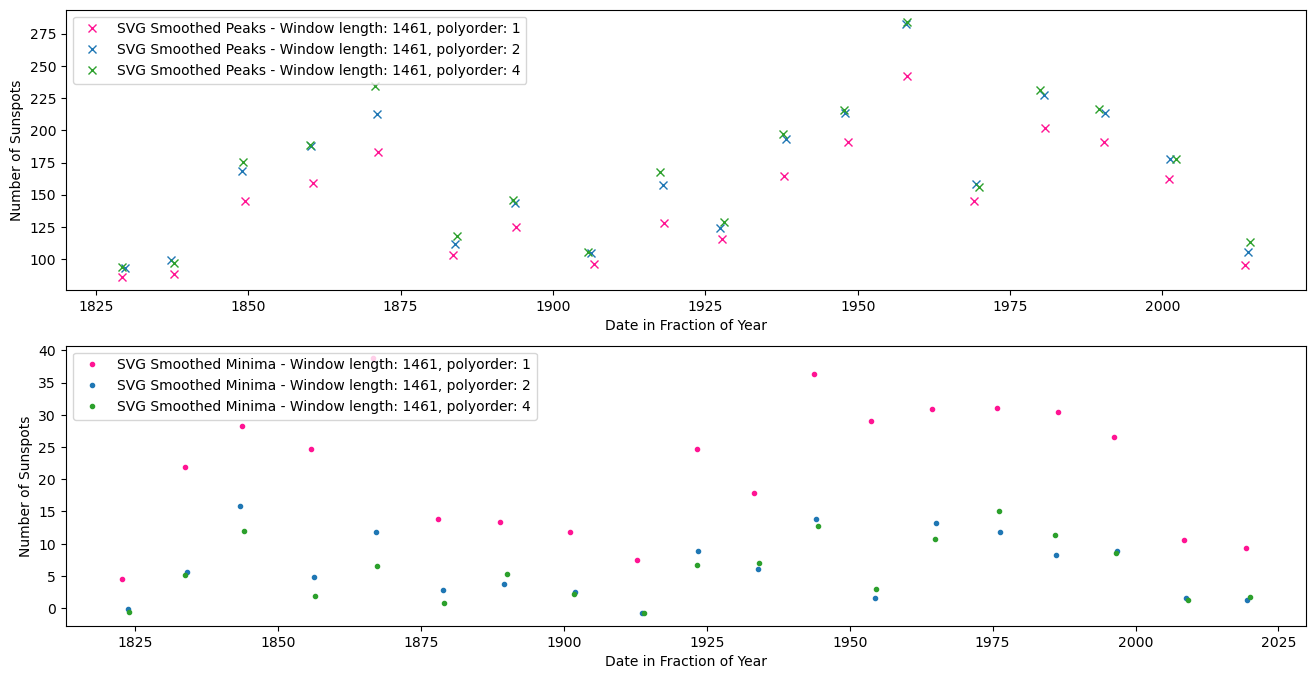

In [11]:
fig, ax = plt.subplots(2, dpi=100, figsize=[16, 8])
for i in range(size):
    ax[0].plot(dates_peak[i], maxima[i], 'x', color=color[i],
           label=f'SVG Smoothed Peaks - Window length: {window_length}, polyorder: {poly_order[i]}')
    ax[1].plot(dates_minima[i], minima[i], '.', color=color[i],
           label=f'SVG Smoothed Minima - Window length: {window_length}, polyorder: {poly_order[i]}')
    for j in range(2):
        ax[j].set_xlabel(xcol)
        ax[j].set_ylabel(ycol)
        ax[j].legend();

#### Comment on plot:
As we can see from the plot above, there appears to be no distinct pattern to the maxima & minima of each peak. As the project progresses, I may be able to create a model which will predict future maxima/minima, and use that model to predict the wider solar activity cycle shape.

What I can do is use the minima to determine where to start my phase diagram above, and also find the average separation between each cycle for the best cycle period approximation.

## Finding the Solar Cycle Period

In [12]:
maxima_time_diff = [np.diff(dates_peak[i]) for i in range(size)] # finds the time difference between successive maxima (years)
minima_time_diff = [np.diff(dates_minima[i]) for i in range(size)] # finds the time difference between successive minima (years)

shortest_max_period = [np.min(maxima_time_diff[i]) for i in range(size)]
longest_max_period = [np.max(maxima_time_diff[i]) for i in range(size)]
shortest_min_period = [np.min(minima_time_diff[i]) for i in range(size)]
longest_min_period = [np.max(minima_time_diff[i]) for i in range(size)]

print(maxima_time_diff, '\n \n', minima_time_diff, '\n')

# Values for SVG polyorder 1
print(f'The shortest period between two solar cycle maxima is {shortest_max_period[0]:.2f} years, with the longest being {longest_max_period[0]:.2f} years')
print(f'The shortest period between two solar cycle minima is {shortest_min_period[0]:.2f} years, with the longest being {longest_min_period[0]:.2f} years')

[array([ 8.485, 11.581, 11.234, 10.709, 12.233, 10.432, 12.773, 11.466,
        9.419, 10.203, 10.601,  9.667, 10.88 , 11.666,  9.739, 10.71 ,
       12.411]), array([ 7.586, 11.573, 11.279, 10.817, 12.907,  9.756, 12.531, 11.773,
        9.425, 10.709,  9.685, 10.129, 11.458, 11.091,  9.988, 10.71 ,
       12.843]), array([ 8.428, 11.438, 10.951, 10.635, 13.493,  9.206, 12.348, 11.732,
       10.438,  9.72 , 10.02 , 10.394, 11.863,  9.973,  9.709, 12.496,
       12.135])] 
 
 [array([10.962, 10.049, 11.945, 10.951, 11.367, 10.803, 12.306, 11.73 ,
       10.435, 10.057, 10.4  , 10.077, 10.561, 11.33 , 10.715,  9.777,
       12.333, 10.764]), array([10.446,  9.288, 12.838, 10.817, 11.731, 10.781, 12.392, 11.647,
        9.86 , 10.427, 10.238, 10.264, 10.791, 11.15 ,  9.735, 10.67 ,
       12.095, 10.742]), array([ 9.781, 10.254, 12.438, 10.943, 11.745, 10.921, 11.77 , 12.23 ,
        9.216, 10.899, 10.344, 10.141, 10.348, 11.134,  9.808, 10.673,
       12.555, 10.849])] 

The shortest p

Without even plotting the phase diagram we can see from these arrays that each solar cycle has a period ranging from 8.48 to 12.77 years (for SVG polyorder 1 signal).

In [13]:
mean_maxima_time_diff = [np.mean(maxima_time_diff[i]) for i in range(size)]
mean_minima_time_diff = [np.mean(minima_time_diff[i]) for i in range(size)]
median_maxima_time_diff = [np.median(maxima_time_diff[i]) for i in range(size)]
median_minima_time_diff = [np.median(minima_time_diff[i]) for i in range(size)]

# Values for SVG polyorder 1
print(f'The mean period between successive maxima is {mean_maxima_time_diff[0]:.3f} years, and the median is {median_maxima_time_diff[0]:.3f} years.') 
print(f'The mean period between successive minima is {mean_minima_time_diff[0]:.3f} years, and the median is {median_minima_time_diff[0]:.3f} years.')

The mean period between successive maxima is 10.836 years, and the median is 10.710 years.
The mean period between successive minima is 10.920 years, and the median is 10.784 years.


In [14]:
average_time_diff = [0.5*(mean_maxima_time_diff[i]+ mean_minima_time_diff[i]) for i in range(size)]
print(average_time_diff)

[10.877967320261444, 10.861411764705878, 10.886364379084968]


Here we see that the average solar cycle period calculated is actually $\approx 10.9$ years, rather than 11 or 11.2 as some papers have suggested.

We can now use the calculated *average time differences* for each SVG signal as the period in our *phase diagram*. First, in order to make the cycle more centred we can find the time at which the first minima occurs and start from that point (so that it looks more like a sine curve).

## Replotting the Phase Diagram

In [15]:
first_minima = [(dates_minima[i].values)[0] for i in range(size)] # year first minima occurs in our df for each SVG
time_difference = [df[xcol][0] - first_minima[i] for i in range(size)] # first recorded time value - first_minima

first_minima

[1822.722, 1823.659, 1823.903]

In [16]:
time = [df[xcol].values + time_difference[1] for i in range(size)]
''' 
Note: using time_difference (i.e. the x-offset) as that for SVG polyorder = 3
      as the first minima for SVG polyorder = 1 is slightly lower than the average
'''
period = [[average_time_diff[i],2*average_time_diff[i]] for i in range(size)]
phase = [time % period[i][j] for i in range(size) for j in range(2)] 

In [17]:
'''
fig, ax = plt.subplots(dpi=150, figsize=[15, 5])
i = 1
ax.scatter(phase[i][j], df[ycol], label='Original Data', color=color[-1],s=s)
for j in range(size):
    ax.scatter(phase[i][j], smoothed[j], 
                  label=f'SV Smoothed - Window length: {window_length}, polyorder: {poly_order[j]}', # plotting SVG1
                  zorder=zorder[j], color=color[j], s=0.25)
    ax.set_xlabel(xcol + f' mod $2T$')
    ax.set_ylabel(ycol)
    ax.legend()
fig.savefig(f'Phase diagram.png')
'''

"\nfig, ax = plt.subplots(dpi=150, figsize=[15, 5])\ni = 1\nax.scatter(phase[i][j], df[ycol], label='Original Data', color=color[-1],s=s)\nfor j in range(size):\n    ax.scatter(phase[i][j], smoothed[j], \n                  label=f'SV Smoothed - Window length: {window_length}, polyorder: {poly_order[j]}', # plotting SVG1\n                  zorder=zorder[j], color=color[j], s=0.25)\n    ax.set_xlabel(xcol + f' mod $2T$')\n    ax.set_ylabel(ycol)\n    ax.legend()\nfig.savefig(f'Phase diagram.png')\n"

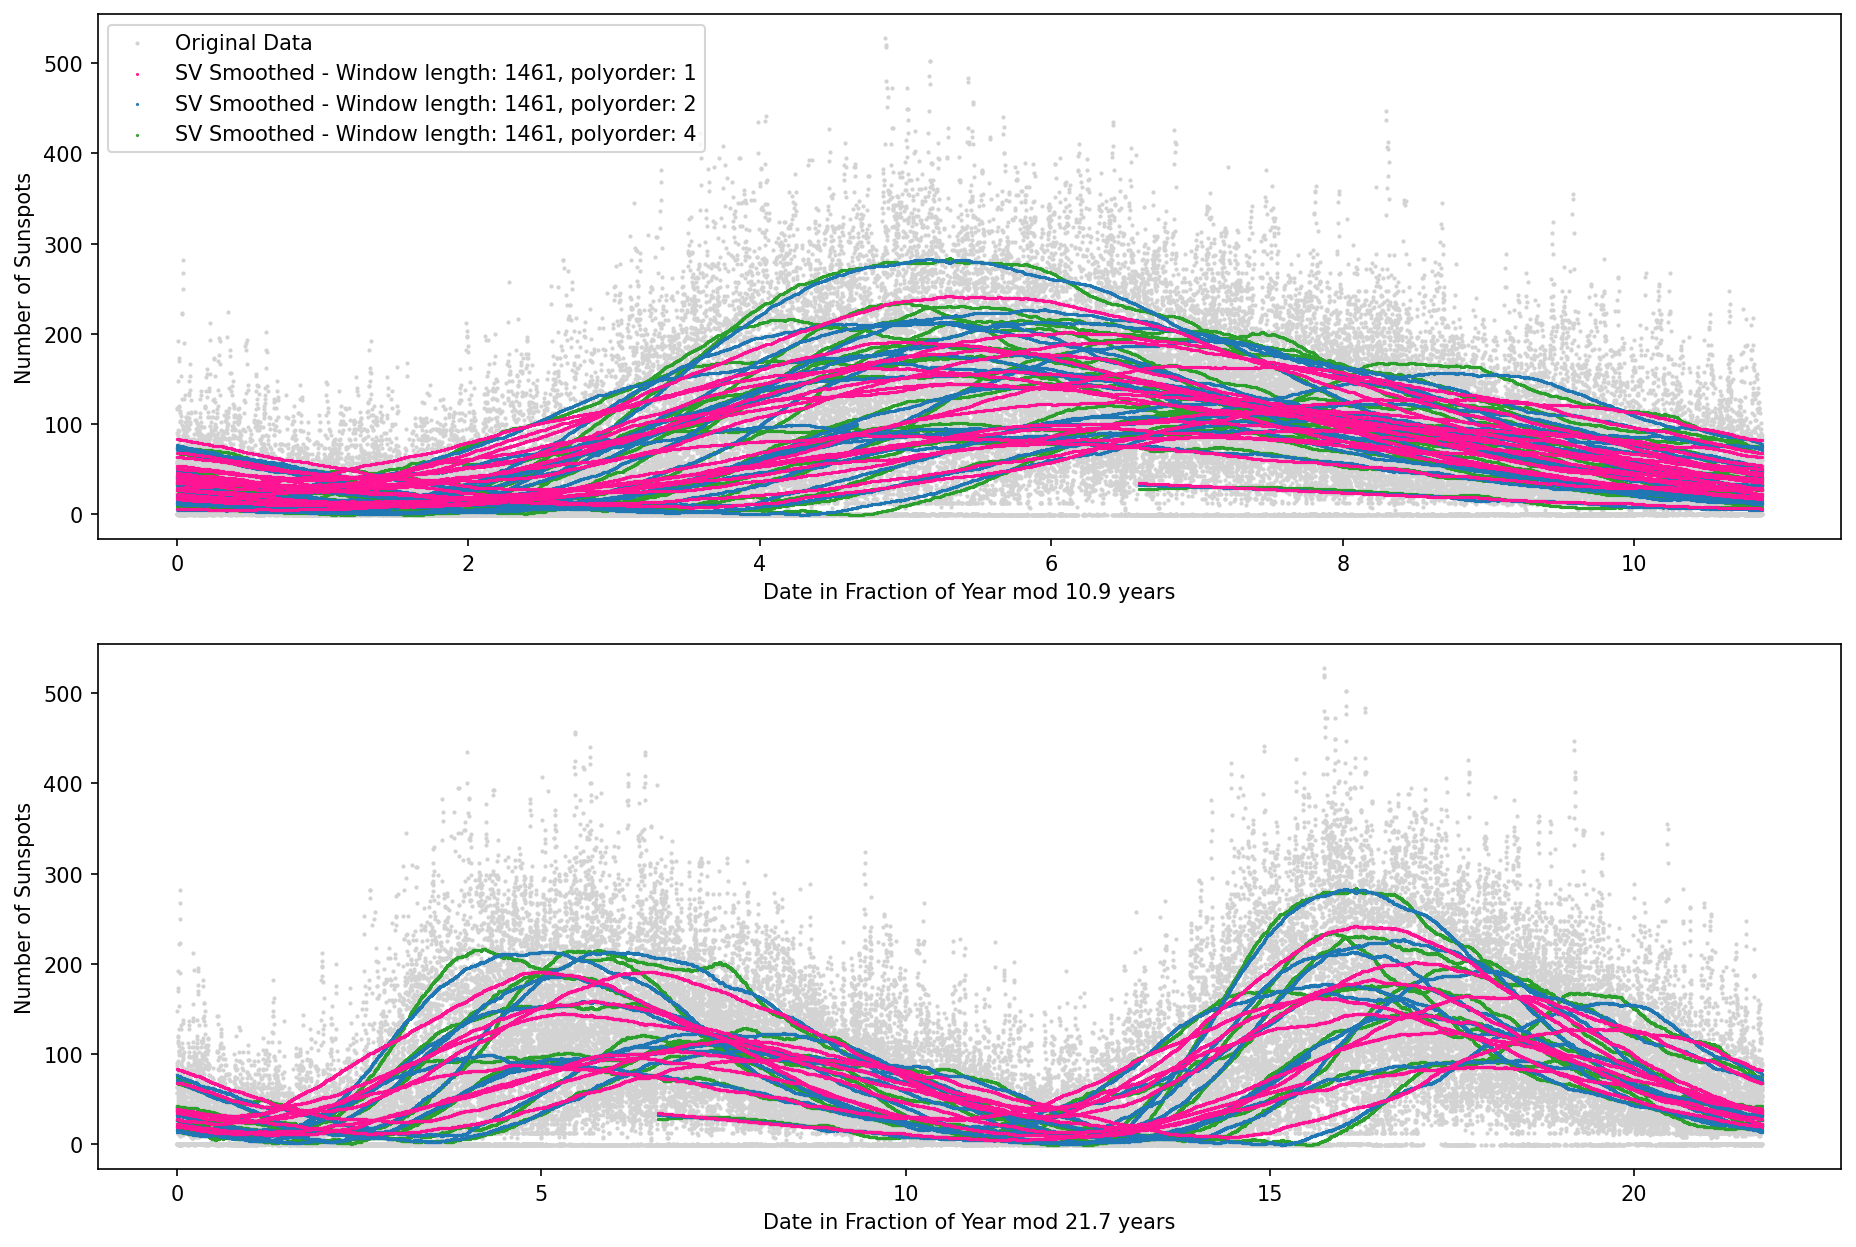

In [20]:
''' Plotting a Phase Diagram '''

fig, ax = plt.subplots(2, dpi=150, figsize=[15, 10])
for i in range(2):
    ax[i].scatter(phase[i][j], df[ycol], label='Original Data', color=color[-1],s=s)
    for j in range(size):
        ax[i].scatter(phase[i][j], smoothed[j], 
                      label=f'SV Smoothed - Window length: {window_length}, polyorder: {poly_order[j]}', # plotting SVG1
                      zorder=zorder[j], color=color[j], s=0.25)
        ax[i].set_xlabel(xcol + f' mod {period[i][i]:.1f} years')
        ax[i].set_ylabel(ycol)
        ax[0].legend()
#fig.savefig(f'Phase diagram.png')

#### Comment on plot:
The above plot shows *more* of the sinusoidal relationship we were looking for, suggesting that the period and phase used here was a better fit than previous. However, there is still a very large phase-difference between each cycle, and so we can still conclude that the period of each cycle is not constant. The two sine-squared graphs below show the type of relationship we expect to see if the cycles have the exact same period.

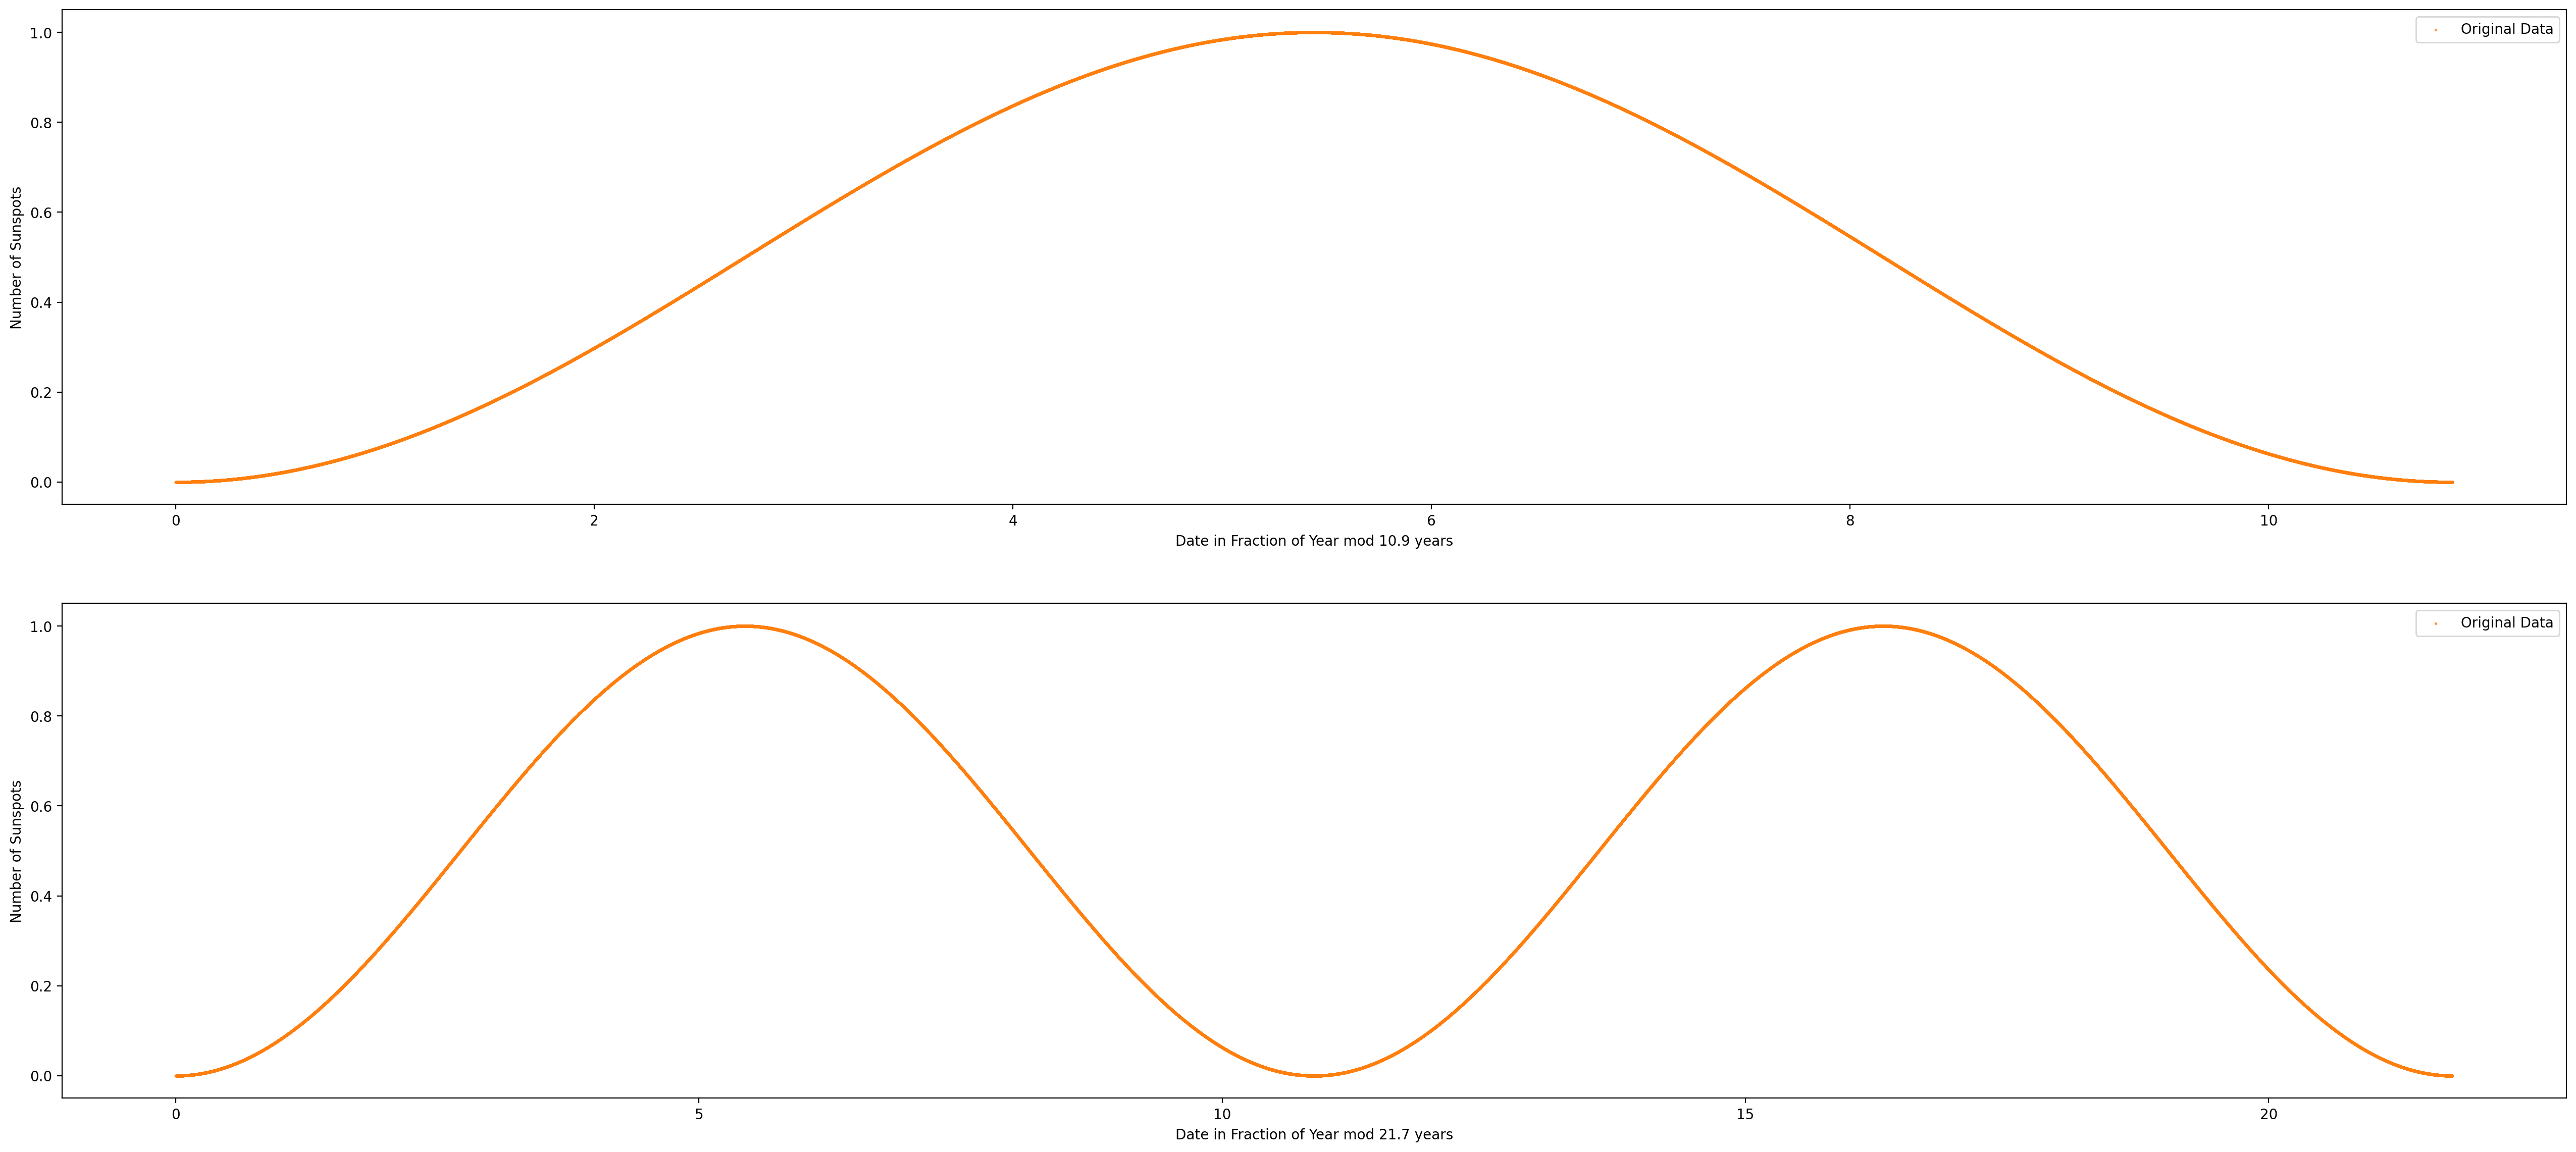

In [21]:
y = [np.sin((i+1)*np.pi / period[i][i] * time[i])**2 for i in range(2) for j in range(size)]
fig, ax = plt.subplots(2, dpi=200, figsize=[32, 14])
for i in range(2):
    ax[i].scatter(phase[i][i], y[i], alpha=alpha, label='Original Data',color='tab:orange',s=s)
    ax[i].set_xlabel(xcol + f' mod {period[i][i]:.1f} years')
    ax[i].set_ylabel(ycol)
    ax[i].legend();

## Finding the descending time of each cycle

Each cycle's period is different, as we have identified. We can go one step further by calculating the time taken for a minima to follow a maxima. One reason we might want to do this is because in the paper https://link.springer.com/article/10.1007/s11207-006-0175-5 they found a *linear relationship* (r = -0.811) between the solar cycle **amplitude** and the **descending time** ***three cycles earlier***.

In [22]:
dates_max = [dates_peak[i].values for i in range(size)]
dates_min = [dates_minima[i][1:].values for i in range(size)] # removing first minima as we don't have the previous maxima

cycles = np.arange(7,len(dates_max[0])+7) # each cycle (starting from cycle 7)
num_cycles = len(cycles)

In [23]:
descending_time = [[dates_min[i][x] - dates_max[i][x] for x in range(num_cycles)] for i in range(size)]

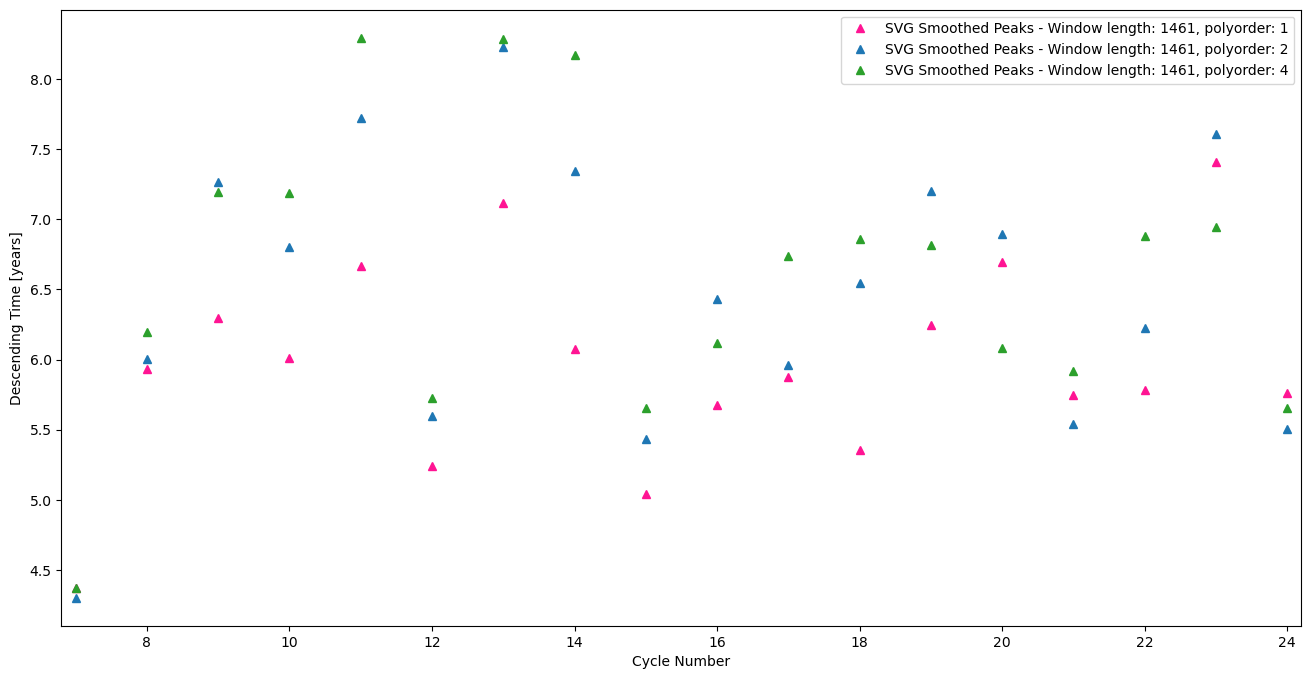

In [24]:
fig, ax = plt.subplots(dpi=100, figsize=[16, 8])
for i in range(size):
    ax.plot(cycles, descending_time[i], '^', color=color[i],
           label=f'SVG Smoothed Peaks - Window length: {window_length}, polyorder: {poly_order[i]}')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('Descending Time [years]')
    ax.set_xlim(6.8,24.2)
    ax.legend();

#### Comment on plot:
This plot shows how the descending time varies for each cycle. Once my data analysis arsenal has widened I could analyse these points and see if there is any predictable pattern. 

## Plotting Descending Time against Cycle Amplitude

Now that we have our descending times, we can test to see if the amplitude is correlated with the descending time three cycles earlier.

In [25]:
descending_time_minus_3 = [descending_time[i][:-3] for i in range(size)] # 3 cycles earlier
maxima_plus_3 = [maxima[i][3:] for i in range(size)] # 3 cycles later
dt_cycles = cycles[3:] # labels of cycles we are now analysing 
dt_cycles

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

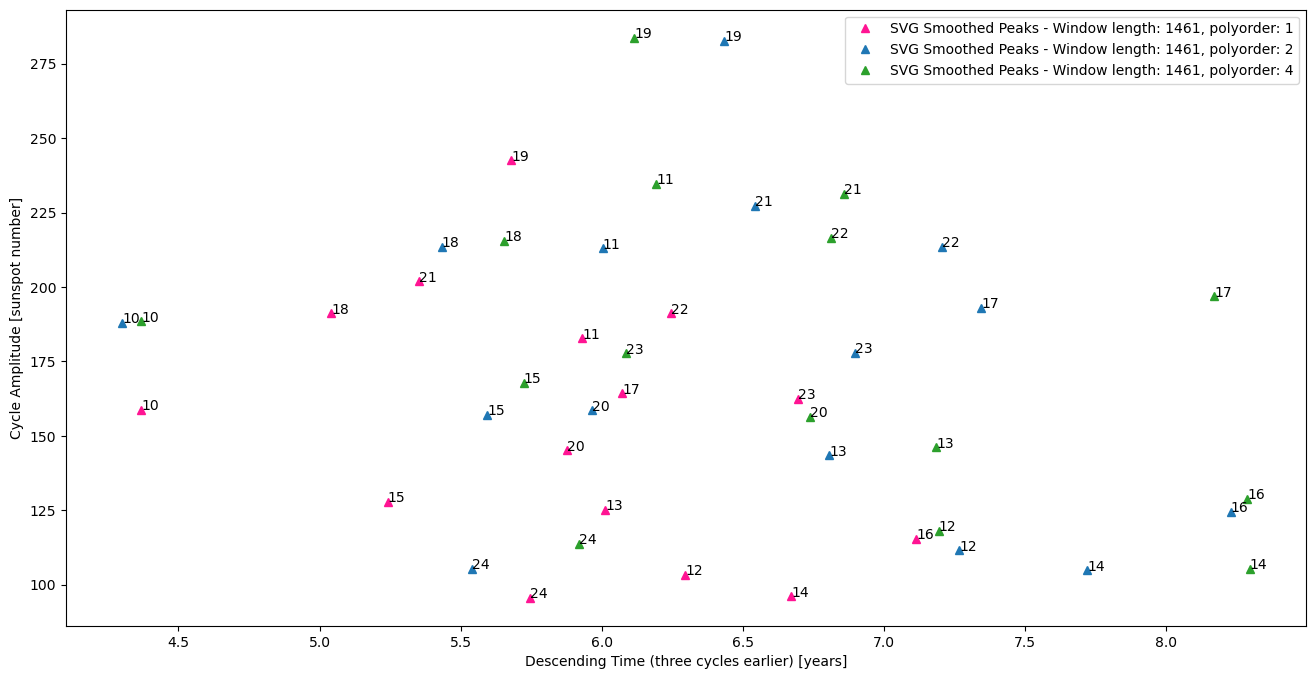

In [26]:
fig, ax = plt.subplots(dpi=100, figsize=[16, 8])
    
for i in range(size):
    ax.plot(descending_time_minus_3[i], maxima_plus_3[i], '^', color=color[i],
           label=f'SVG Smoothed Peaks - Window length: {window_length}, polyorder: {poly_order[i]}')
    for j, cycle in enumerate(dt_cycles):
        ax.annotate(cycle, (descending_time_minus_3[i][j], maxima_plus_3[i][j])) # labelling each cycle
    ax.set_ylabel('Cycle Amplitude [sunspot number]')
    ax.set_xlabel('Descending Time (three cycles earlier) [years]')
    ax.legend();

#### Comment on plot:
The graph above looks just as random as the previous one, suggesting there is no clear relationship between cycle amplitude and descending time. However, to analyse this robustly, using the tools at our disposal, we can fit it with the linear regression code created earlier. 

This will be done in a different notebook.

## Creating csv's

In [27]:
# SVG Signals
X = df[xcol]
for i in range(size):
    poly = poly_order[i]
    data = np.vstack([X, smoothed[i]]).T
    cols = ['Year', 'Sunspot_Number']
    df = pd.DataFrame(data=data, columns=cols)
    #df.to_csv(f'SVG_poly{poly}.csv') # uncomment this line to save new data

In [28]:
# Descending Time 
for i in range(size):
    poly = poly_order[i]
    data = np.vstack([descending_time_minus_3[i], maxima_plus_3[i]]).T
    cols = ['Descending_Time', 'Solar_Cycle_Maxima']
    df = pd.DataFrame(data=data, columns=cols)
    #df.to_csv(f'tmp_dt_polyorder{poly}.csv') # uncomment this line to save new data

In [29]:
# Maxima
for i in range(size):
    poly = poly_order[i]
    data = np.vstack([dates_peak[i], maxima[i]]).T
    cols = ['Year', 'Solar_Cycle_Maxima']
    df = pd.DataFrame(data=data, columns=cols)
    #df.to_csv(f'maxima_poly{poly}.csv') # uncomment this line to save new data

# Using different Sunspot Data

This is data of *monthly mean total sunspot number*, and so isn't dotted with lots of zeros, as is the case above (which makes Gaussian Process Regression difficult).
https://www.kaggle.com/datasets/robervalt/sunspots?resource=download

In [30]:
df = pd.read_csv (r'Data/Sunspots.csv')
df.head()

Unnamed: 0        Date  Monthly Mean Total Sunspot Number
0           0  1749-01-31                               96.7
1           1  1749-02-28                              104.3
2           2  1749-03-31                              116.7
3           3  1749-04-30                               92.8
4           4  1749-05-31                              141.7

In [31]:
xcol = 'Date'
ycol = 'Monthly Mean Total Sunspot Number'

X = df[xcol].values
y = df[ycol].values

In [32]:
from datetime import datetime

time = []
for i in range(len(X)):
    time.append(datetime.strptime(X[i], '%Y-%m-%d'))

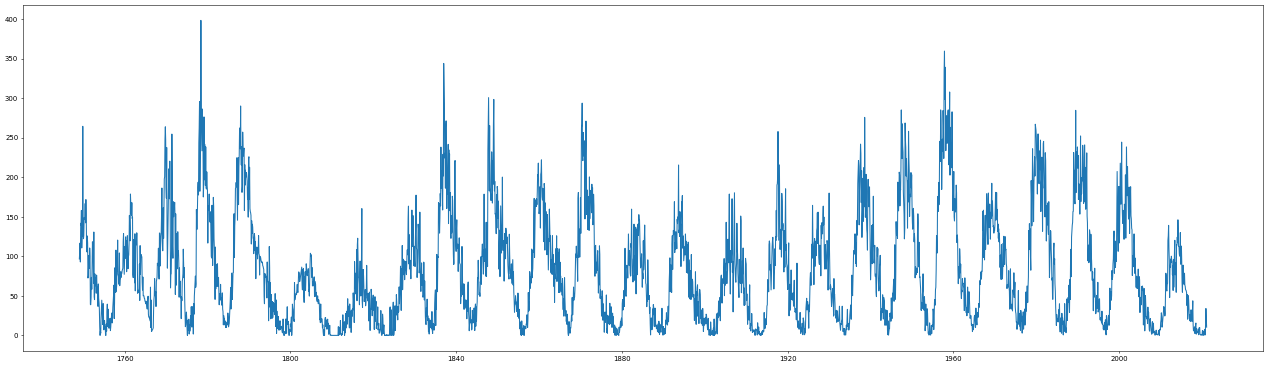

In [33]:
fig, ax = plt.subplots(dpi=50, figsize=[32, 9])
ax.plot(time,y);